<a href="https://colab.research.google.com/github/wxmiked/cannabis-deforestation/blob/feature-add-download-naip/notebooks/custom_raster_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAIP Custom Raster Datasets

Mike Dvorak [mike@weathertactics.io](mailto:mike@weathertactics.io)

A custom `GeoDataset` class for the [Microsoft Planetary Computer NAIP archive](https://planetarycomputer.microsoft.com/dataset/naip). This notebook is derived from the Custom Raster Datasets tutorial on the TorchGeo site originally written by Ritwik Gupta.

## Setup

First, we install TorchGeo and a couple of other dependencies for downloading data from Microsoft's Planetary Computer.

In [18]:
%pip install torchgeo planetary_computer pystac

Note: you may need to restart the kernel to use updated packages.


## Imports

Next, we import TorchGeo and any other libraries we need.

In [19]:
import os
import tempfile
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from torch.utils.data import DataLoader

from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler
from torchgeo.transforms import AppendNDBI, AppendNDVI, AppendNDWI

%matplotlib inline
plt.rcParams['figure.figsize'] = (4, 4)

## Downloading

Let's download some data to play around with. In this example, we'll create a dataset for loading Sentinel-2 images. Yes, TorchGeo already has a built-in class for this, but we'll use it as an example of the steps you would need to take to add a dataset that isn't yet available in TorchGeo. We'll show how to download a few bands of Sentinel-2 imagery from the Planetary Computer. This may take a few minutes.

In [20]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [21]:
time_range = "2016-01-01/2016-12-31"
bbox = [-120.56802294590112,38.307368125981206,-120.47440785318257,38.36284893862011]


search = catalog.search(collections=["naip"], bbox=bbox, datetime=time_range)
items = search.item_collection()
items

In [22]:
import os
from urllib.parse import urlparse
import tempfile

root = os.path.join(tempfile.gettempdir(), 'naip')
os.makedirs(root, exist_ok=True)  # Ensure the directory exists

for item in items:
    signed_item = planetary_computer.sign(item)
    url = signed_item.assets["image"].href
    filename = urlparse(url).path.split('/')[-1]
    
    # Check if file already exists
    filepath = os.path.join(root, filename)
    if not os.path.exists(filepath):
        print(f"Downloading {filename}...")
        download_url(url, root, filename)
    else:
        print(f"Skipping {filename} - already exists")

Skipping m_3812045_sw_10_h_20160620.tif - already exists
Skipping m_3812045_nw_10_h_20160620.tif - already exists
Skipping m_3812044_sw_10_h_20160620.tif - already exists
Skipping m_3812044_se_10_h_20160620.tif - already exists
Skipping m_3812044_nw_10_h_20160620.tif - already exists
Skipping m_3812044_ne_10_h_20160620.tif - already exists


This downloads the following files:

In [23]:
print(root)
sorted(os.listdir(root))

/var/folders/56/gwh1m3s973l4jc97_wdr2qqw0000gn/T/naip


['m_3812044_ne_10_h_20160620.tif',
 'm_3812044_nw_10_h_20160620.tif',
 'm_3812044_se_10_h_20160620.tif',
 'm_3812044_sw_10_h_20160620.tif',
 'm_3812045_nw_10_h_20160620.tif',
 'm_3812045_sw_10_h_20160620.tif']

## Defining a custom NAIP dataset

Using the filenames above, we can create new NAIP class that is a sub-class of `RasterDataset`. We also add a plotting function.

In [24]:
class Naip(RasterDataset):
    filename_glob = 'm_*.tif'
    filename_regex = r'^m_[0-9]{7}_[nsew]{2}_10_h_(?P<date>\d{8})'
    date_format = '%Y%m%d'
    is_image = True
    separate_files = False
    all_bands = ('R', 'G', 'B', 'NIR')
    rgb_bands = ('R', 'G', 'B',)

    # Normalize image to [0, 1]
    def __getitem__(self, index):
        sample = super().__getitem__(index)
        image = sample['image']
        image = (image - image.min()) / (image.max() - image.min())
        sample['image'] = image
        return sample

    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder the image
        image = sample['image'][rgb_indices].permute(1, 2, 0)

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

In [25]:
naip_dataset = Naip(root)
print(naip_dataset)

Naip Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=707316.0, maxx=724386.0, miny=4236066.0, maxy=4250688.0, mint=1466406000.0, maxt=1466492399.999999)
    size: 6


Let's plot an image to see what it looks like. We'll use `RandomGeoSampler` to load small patches from each image.

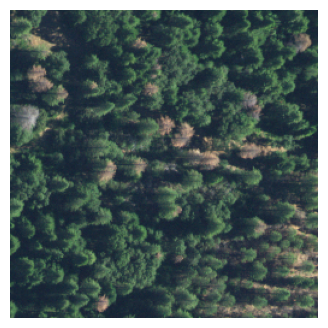

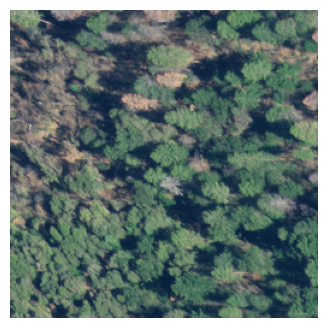

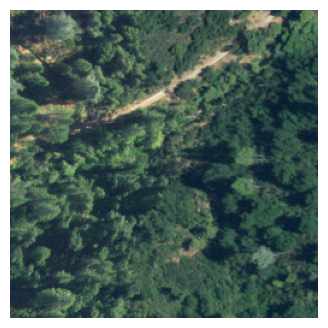

In [26]:
naip_dataset = Naip(root)
g = torch.Generator().manual_seed(1)
sampler = RandomGeoSampler(naip_dataset, size=256, length=3)
dataloader = DataLoader(naip_dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    naip_dataset.plot(sample)
    plt.axis('off')
    plt.show()
    plt.close()

# NDVI

Append Normalized Difference Vegetation Index (NDVI) and Normalized Difference Water Index (NDWI).

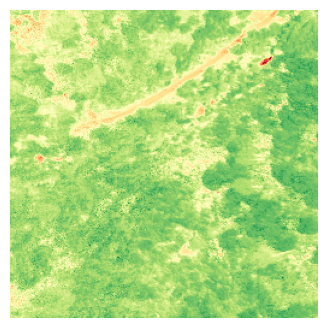

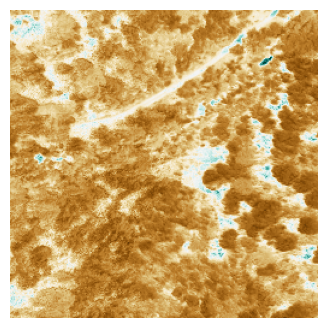

In [27]:
# NDVI is appended to channel dimension (dim=0)
indexNdvi = AppendNDVI(index_nir=naip_dataset.all_bands.index('NIR'), index_red=naip_dataset.all_bands.index('R'))
image = sample['image']
image = indexNdvi(image)[0]

# Normalize from [-1, 1] -> [0, 1] for visualization
image[-1] = (image[-1] + 1) / 2


plt.imshow(image[-1], cmap='RdYlGn')
plt.axis('off')
plt.show()
plt.close()

# NDWI is appended to channel dimension (dim=0)
indexNdwi = AppendNDWI(index_green=naip_dataset.all_bands.index('G'), index_nir=naip_dataset.all_bands.index('NIR'))
image = sample['image']
image = indexNdwi(image)[0]

# Normalize from [-1, 1] -> [0, 1] for visualization
image[-1] = (image[-1] + 1) / 2

plt.imshow(image[-1], cmap='BrBG')
plt.axis('off')
plt.show()
plt.close()

# CannabisParcelDataset

We use the parcels that are either cannabis permit parcels or not to train the model.

In [28]:
import torch
import logging
from torch.utils.data import Dataset
from torchgeo.datasets import VectorDataset

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class CannabisParcelDataset(Dataset):
    def __init__(self, naip_dataset, permitted_shp, transform=None):
        """
        Args:
            naip_dataset: An instance of your Naip(RasterDataset) class.
            permitted_shp: File path to the shapefile for permitted cannabis parcels.
            transform: Optional transform to be applied on a sample.
        """
        logger.info("Initializing CannabisParcelDataset...")
        self.naip = naip_dataset  # Instance of Naip(RasterDataset)
        self.transform = transform
        
        # Load parcel shapefiles using GeoPandas.
        logger.info(f"Loading cannabis permits from {permitted_shp}")
        cannabis_permit = VectorDataset(paths=permitted_shp, label_name="cannabis_permit")
        logger.info("Intersecting NAIP data with cannabis permits...")
        self.cannabis_permit_naip = self.naip & cannabis_permit
        logger.info(f"Dataset initialized with {len(self)} samples")
    
    def __len__(self):
        return len(self.cannabis_permit_naip)
    
    def __getitem__(self, idx):
        logger.debug(f"Getting item {idx}")
        # Get the item from the intersected dataset
        sample = self.cannabis_permit_naip[idx]
        
        # Extract the image and label
        patch = sample['image']
        label = sample['label']
        
        # Apply any additional transforms (e.g., normalization, augmentation)
        if self.transform:
            patch = self.transform(patch)
        
        # Convert label to tensor if it isn't already
        if not isinstance(label, torch.Tensor):
            label = torch.tensor(label, dtype=torch.long)
            
        return patch, label

In [29]:
# Assuming Naip is defined elsewhere and imported
dataset = CannabisParcelDataset(
    naip_dataset=naip_dataset,
    permitted_shp="../cannabis-parcels/cannabis-registry-2018-commercial-permits-parcels.gpkg"
)
print(len(dataset))

INFO:__main__:Initializing CannabisParcelDataset...
INFO:__main__:Loading cannabis permits from ../cannabis-parcels/cannabis-registry-2018-commercial-permits-parcels.gpkg
INFO:__main__:Intersecting NAIP data with cannabis permits...
INFO:__main__:Dataset initialized with 6 samples


Converting VectorDataset CRS from EPSG:4326 to EPSG:26910
Converting VectorDataset res from 0.0001 to 0.6
6


# LightningModel and DataModule

In [30]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchgeo.models import Swin_V2_B_Weights

class CannabisDataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size: int = 32,
        num_workers: int = 4,
        train_val_split: float = 0.8
    ):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_val_split = train_val_split

    def setup(self, stage=None):
        # Create full dataset
        full_dataset = dataset
        
        # Split into train and val
        train_size = int(self.train_val_split * len(full_dataset))
        val_size = len(full_dataset) - train_size
        
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(
            full_dataset, [train_size, val_size]
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False
        )
    


In [31]:
import torch
import pytorch_lightning as pl
from torch import nn
from torchmetrics import Accuracy
from torchgeo.models import Swin_V2_B_Weights, swin_v2_b

class CannabisModel(pl.LightningModule):
    def __init__(self, learning_rate: float = 1e-3):
        super().__init__()
        self.learning_rate = learning_rate
        
        # Load pretrained Swin Transformer model with NAIP weights
        self.model = swin_v2_b(weights=Swin_V2_B_Weights.NAIP_RGB_MI_SATLAS)
        
        # Modify the final layer for binary classification
        num_features = self.model.head.in_features
        self.model.head = nn.Linear(num_features, 1)
        
        # Initialize metrics
        self.train_acc = Accuracy(task="binary")
        self.val_acc = Accuracy(task="binary")
        
        # Loss function
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)  # Ensure data is on the correct device
        y = y.to(self.device)
        y_hat = self(x)
        loss = self.criterion(y_hat.squeeze(), y.float())
        
        # Update metrics
        self.train_acc(y_hat.squeeze().sigmoid(), y)
        
        # Log metrics
        self.log("train_loss", loss)
        self.log("train_acc", self.train_acc)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat.squeeze(), y.float())
        
        # Update metrics
        self.val_acc(y_hat.squeeze().sigmoid(), y)
        
        # Log metrics
        self.log("val_loss", loss)
        self.log("val_acc", self.val_acc)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Training

In [32]:
# # First define the callbacks
# checkpoint_callback = ModelCheckpoint(
#     monitor="val_loss",
#     dirpath="checkpoints",
#     filename="cannabis-{epoch:02d}-{val_loss:.2f}",
#     save_top_k=3,
#     mode="min"
# )

# early_stopping = EarlyStopping(
#     monitor="val_loss",
#     patience=5,
#     mode="min"
# )

trainer = pl.Trainer(
    max_epochs=50,
    # callbacks=[checkpoint_callback, early_stopping],
    accelerator="auto",
    devices=1,
    # Add these parameters for more verbose output
    enable_progress_bar=True,
    enable_model_summary=True,
    log_every_n_steps=1,  # Log more frequently
    # Add these to help with debugging
    num_sanity_val_steps=2,  # Reduce number of validation steps during sanity check
    fast_dev_run=False,  # Set to True to run a quick test
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [33]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import os
os.environ['PYTHONPATH'] = os.getcwd()

def train():
    # Initialize data module
    data_module = CannabisDataModule(
        batch_size=8, # was 32
        num_workers=2 # was 4
    )

    # Initialize model
    model = CannabisModel(learning_rate=1e-3)

    # Define callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints",
        filename="cannabis-{epoch:02d}-{val_loss:.2f}",
        save_top_k=3,
        mode="min"
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=5,
        mode="min"
    )

    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=50,
        callbacks=[checkpoint_callback, early_stopping],
        accelerator="auto",
        devices=1
    )
    # Add this before trainer.fit()
    trainer.validate(model, data_module)  # Test validation first

    # Train the model
    trainer.fit(model, data_module)

train()


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Validation: |          | 0/? [00:00<?, ?it/s]

Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^    ^exitcode = _main(fd, parent_sentinel)^
^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'CannabisParcelDataset' on <module '__main__' (built-in)>    
self

RuntimeError: DataLoader worker (pid(s) 70437, 70438) exited unexpectedly